## Импорты

In [ ]:
! pip install transformers datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# данные и eda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from pymystem3 import Mystem
from tqdm import tqdm
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# classic ml models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import jaccard_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.multioutput import ClassifierChain
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# transformer models
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

# график
sns.set_theme(style="whitegrid", palette="muted")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1. Датасет

Скачаем данные

In [ ]:
ds = load_dataset("seara/ru_go_emotions", "simplified")

df_train = pd.DataFrame(ds['train'])
df_val = pd.DataFrame(ds['validation'])
df_test = pd.DataFrame(ds['test'])

df = pd.concat([df_train, df_val, df_test], axis=0, ignore_index=True)

Датасет представляет собой набор текстов на английском (text), их переводов на русский (ru_text), и таргетов - списка из нескольких классов, соответствующих эмоциям, которые встречаются в тексте

In [ ]:
print("Dataset head:")
display(df.head(5))

Dataset head:


,ru_text,text,labels,id
0,"Моя любимая еда — это все, что мне не приходил...",My favourite food is anything I didn't have to...,[27],eebbqej
1,"Теперь, если он покончит с собой, все будут ду...","Now if he does off himself, everyone will thin...",[27],ed00q6i
2,КАКОГО НАХРАНА БЭЙЛЕССКАЯ ИЗОИНЦИЯ?,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,Чтобы она почувствовала угрозу,To make her feel threatened,[14],ed7ypvh
4,Грязные южные дрочники,Dirty Southern Wankers,[3],ed0bdzj


Пустых значений нет, так что можем ничего не чистить и работать с датасетом как есть

In [ ]:
print("\nDataset info:")
print(df.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54263 entries, 0 to 54262
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ru_text  54263 non-null  object
 1   text     54263 non-null  object
 2   labels   54263 non-null  object
 3   id       54263 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB
None


## 2. EDA

Посчитаем общее количество вхождений каждой эмоции

In [ ]:
emotion2id = {0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval", 5: "caring",
              6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment", 10: "disapproval", 11: "disgust", 12: "embarrassment",
              13: "excitement", 14: "fear", 15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness", 20: "optimism",
              21: "pride", 22: "realization", 23: "relief", 24: "remorse", 25: "sadness", 26: "surprise", 27: "neutral"}

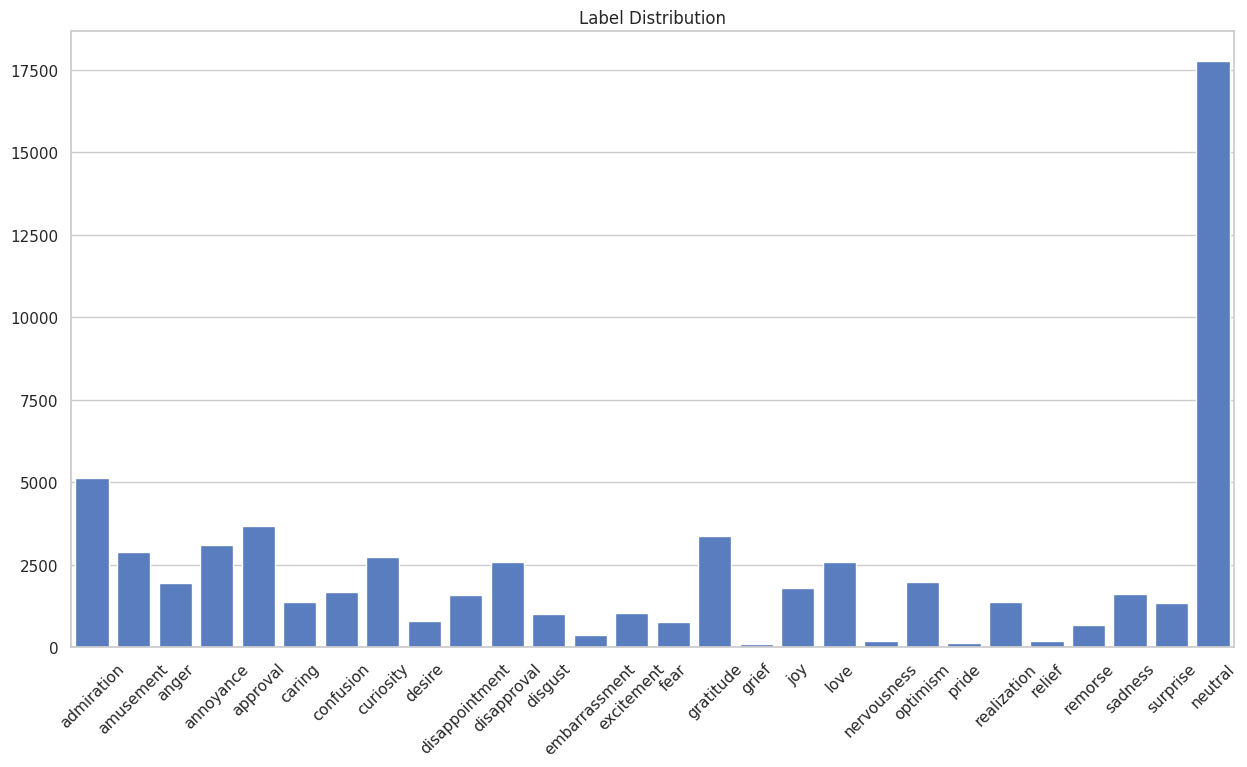

In [ ]:
all_labels = df['labels'].tolist()
labels_list = []
for label in all_labels:
  for l in label:
    labels_list.append(l)
labels, counts = np.unique(np.array(labels_list), return_counts=True)
plt.figure(figsize=(15,8))
sns.barplot(x=[emotion2id[x] for x in labels], y=counts)
plt.title("Label Distribution")
plt.xticks(rotation=45)
plt.show()

Как можно видеть, в датасете сильный дисбланс классов. Больше всего объектов относится к классу neutral. есть совсем малочисленные классы - например, grief

Также посмотрим, сколько всего эмоций в среднем приходится на один текст:

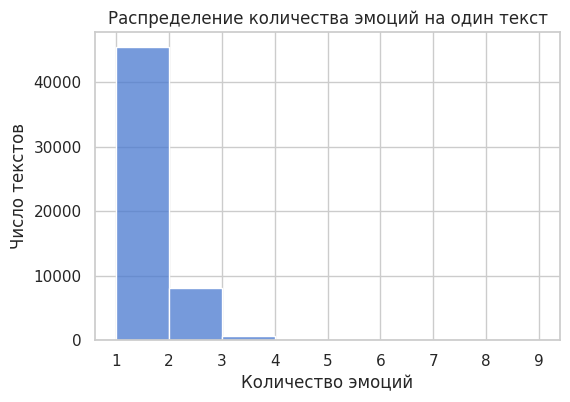

In [ ]:
num_labels_per_text = [len(x) for x in df['labels'].tolist()]
plt.figure(figsize=(6,4))
sns.histplot(num_labels_per_text, bins=range(1,10), kde=False)
plt.title("Распределение количества эмоций на один текст")
plt.xlabel("Количество эмоций")
plt.ylabel("Число текстов")
plt.show()

То есть в основной массе предсказывать стоит 1-2 тэга классса для объекта

Посмотрим на длины текстов в датасете

count    54263.000000
mean        73.333911
std         40.943859
min          2.000000
25%         39.000000
50%         69.000000
75%        102.000000
max        703.000000
Name: text_length, dtype: float64


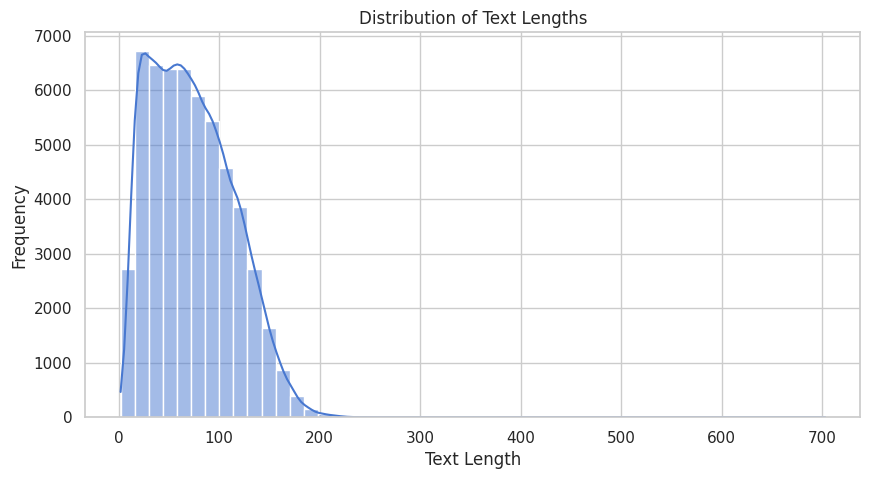

In [ ]:
df['text_length'] = df['ru_text'].apply(len)
print(df['text_length'].describe())
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

С самим характером текстов повезло - они короткие, что сэкономит время на вычисление и память

Далее посмотрим на то, какие самые частые слова встречаются в тексте, чтобы оценить, есть ли возможность ввести rule-based подход, достаточно ли отличаются между собой текста разных классов

In [ ]:
# лемматизация с помощью mystem
m = Mystem()
# убираем стоп-слова
stop_words = set(stopwords.words('russian'))
all_words = ' '.join(df['ru_text'])
lemmas = m.lemmatize(all_words)
# чистим от пунктуации и пустых значений
lemmas = [l.replace(' ', '').translate(str.maketrans('', '', punctuation + "«»")) for l in lemmas]
lemmas = [l for l in lemmas if l != '' and l not in stop_words]

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz



Most common words:
         word  count
0         это  19292
1         имя   9893
2        мочь   4243
3     человек   3123
4     который   3094
5      просто   3077
6     спасибо   2904
7      думать   2519
8        свой   2458
9       очень   2377
10    хороший   2344
11      знать   2204
12       весь   2120
13      самый   1790
14     хотеть   1773
15        год   1690
16  нравиться   1680
17   говорить   1674
18    сделать   1639
19      иметь   1549


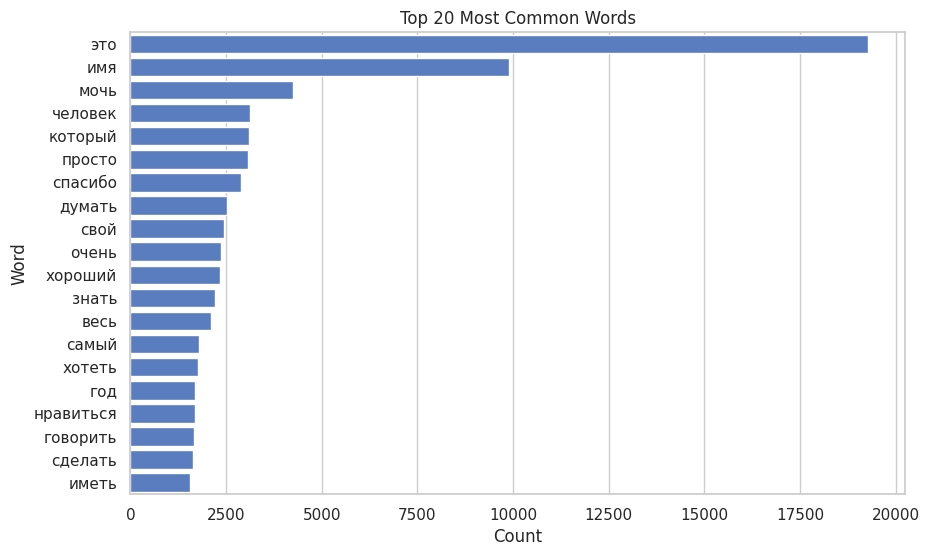

In [ ]:
print("\nMost common words:")
common_words = Counter(lemmas).most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])
print(common_words_df)
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=common_words_df)
plt.title("Top 20 Most Common Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

На эту статистику самое большое влияние оказали, скорее всего, текста из класса neutral. У нас возник вопрос, почему в этом списке (и в многих других, см. ниже) возникает слово 'имя' - это плейсхолдер для ника пользователя ([ИМЯ]), т.к. переписки брались из социальных сетей

Посмотрим теперь, какие слова ассоциируются с определенными классами

In [ ]:
# обработка, как в предыдущем случае, только теперь сохраняем обработанное в dict по классам
label_texts = {}

m = Mystem()
stop_words = set(stopwords.words('russian'))

for i in range(len(df)):
  labels = df.iloc[i]['labels']
  text = df.iloc[i]['ru_text']
  lemmas = m.lemmatize(text)
  lemmas = [l.replace(' ', '').translate(str.maketrans('', '', punctuation + "«»")) for l in lemmas]
  lemmas = [l for l in lemmas if l != '' and l not in stop_words]
  for label in labels:
    if label not in label_texts:
      label_texts[label] = lemmas
    else:
      label_texts[label] += lemmas

In [ ]:
# выделяем топ-10 для каждого класса
common_words = {}
for label in label_texts.keys():
    common_words_label = Counter([x for x in label_texts[label] if x != '\n']).most_common(10)
    common_words[label] = common_words_label

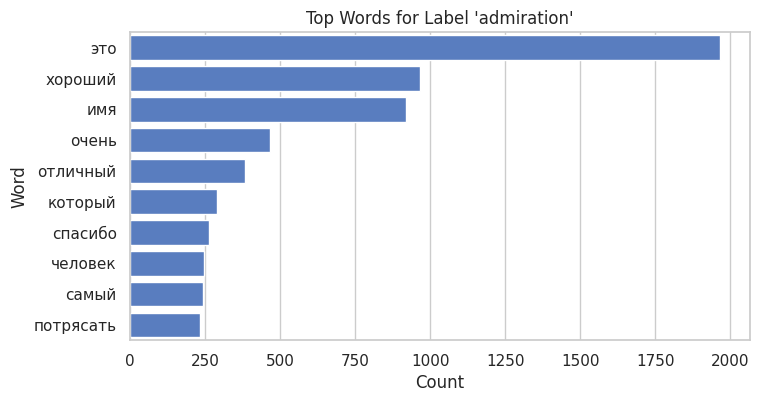

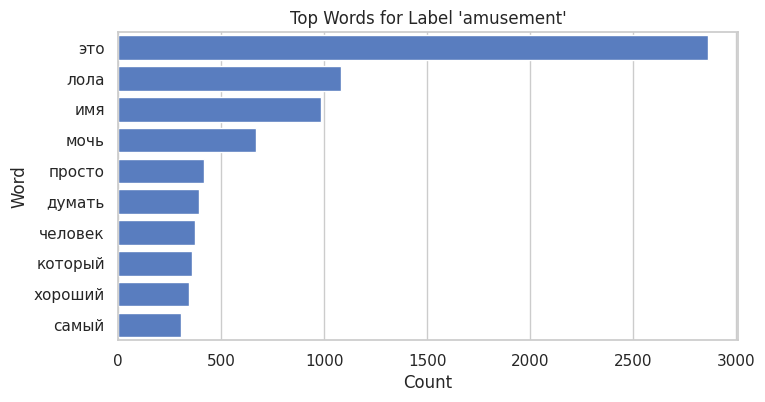

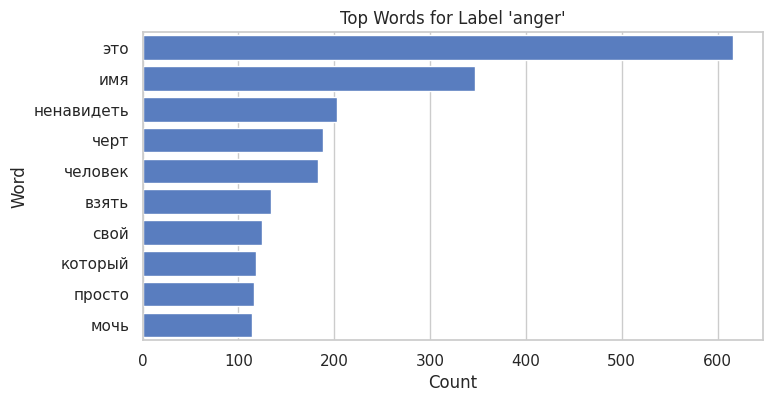

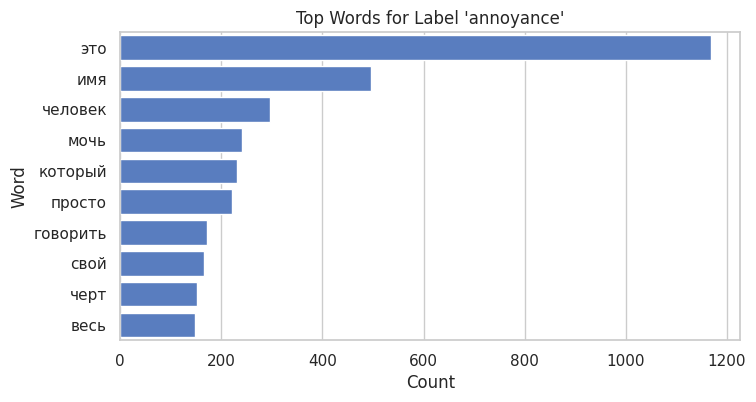

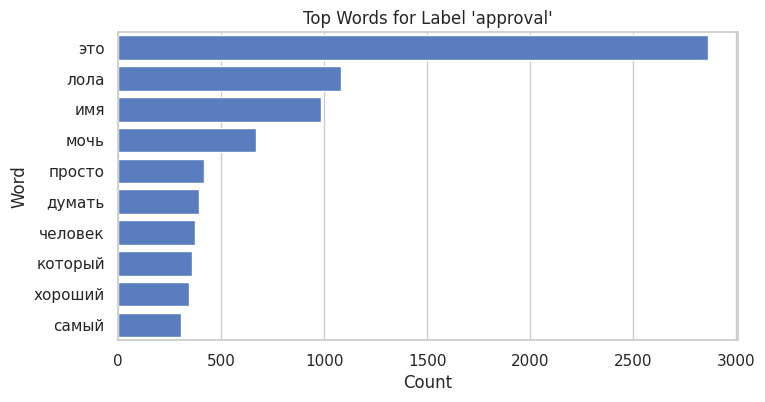

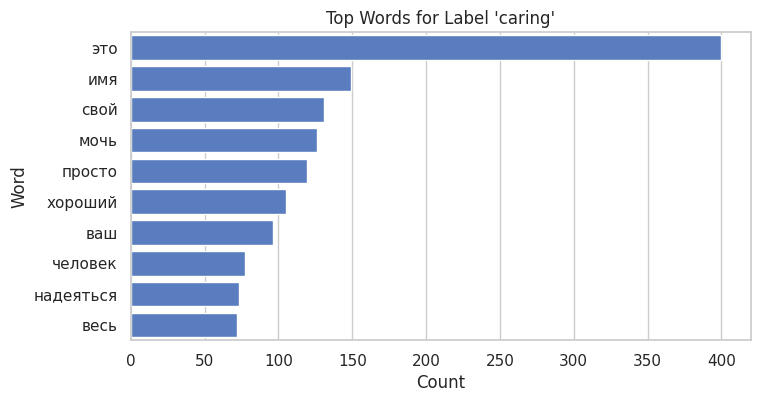

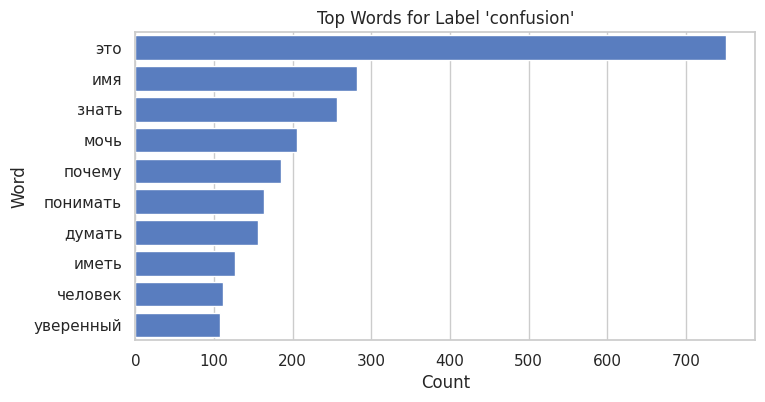

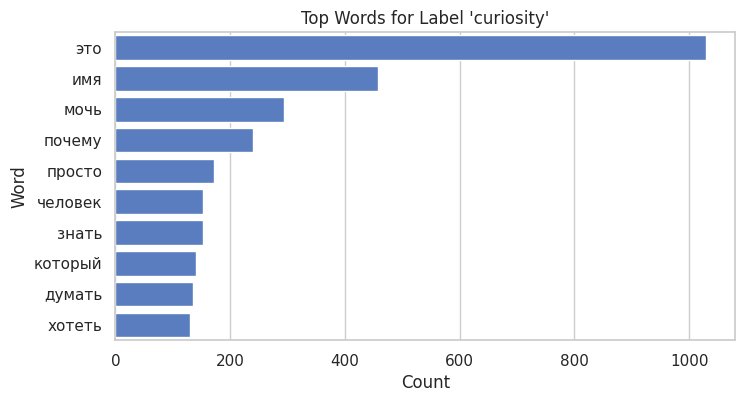

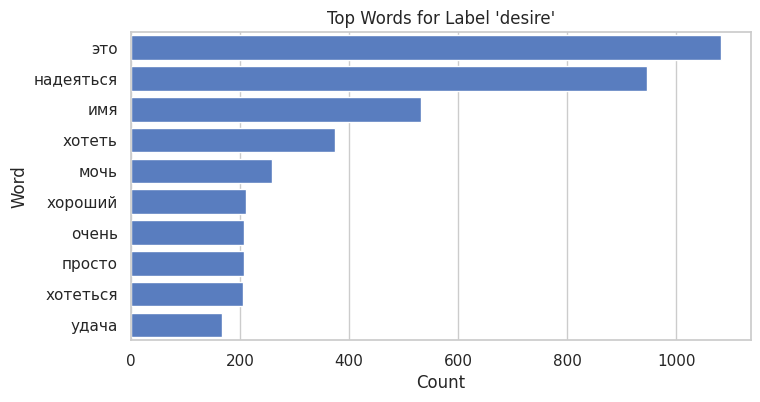

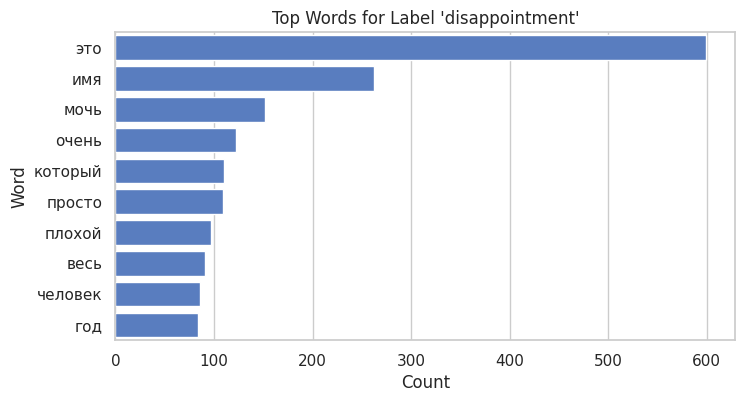

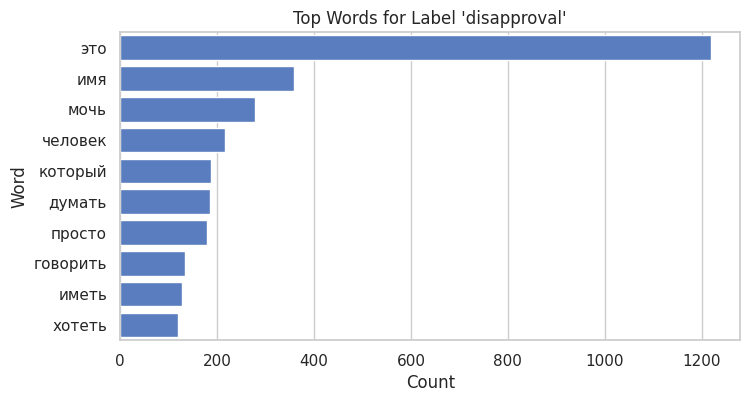

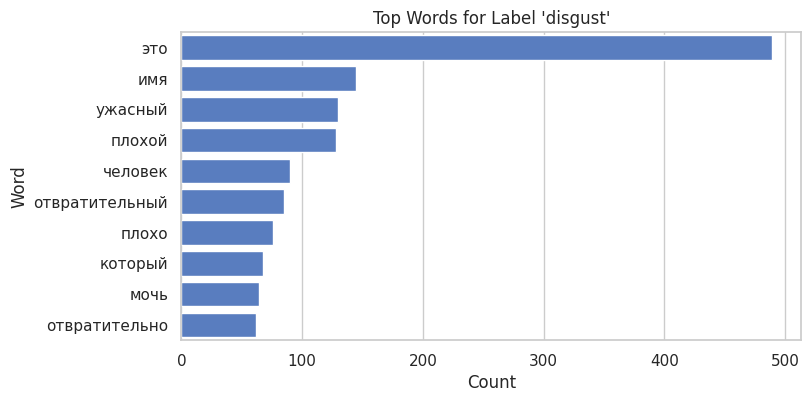

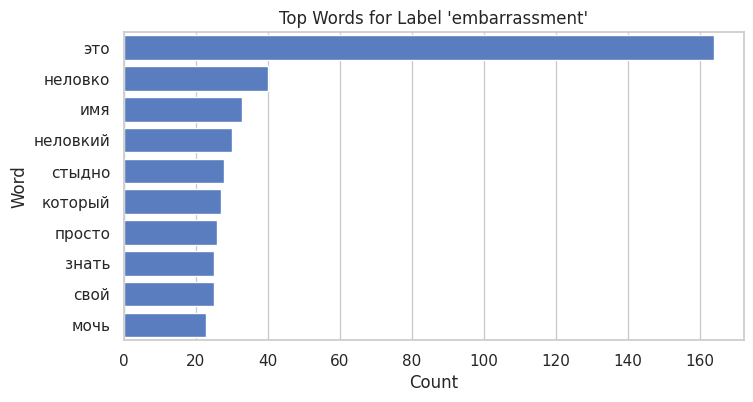

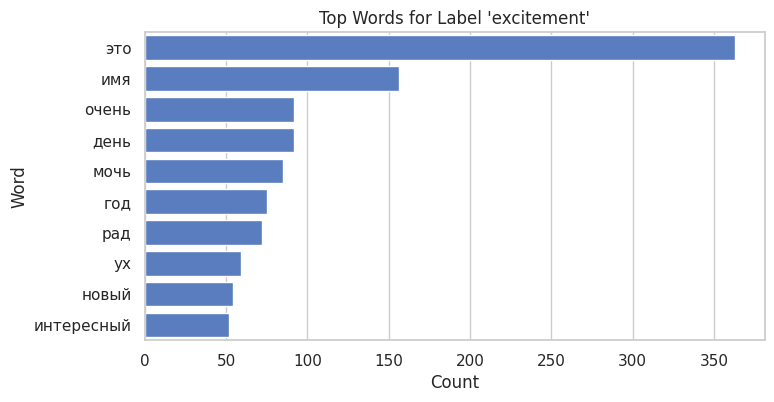

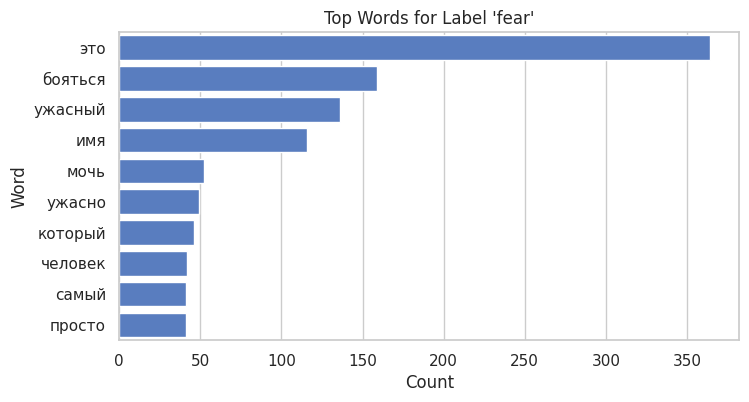

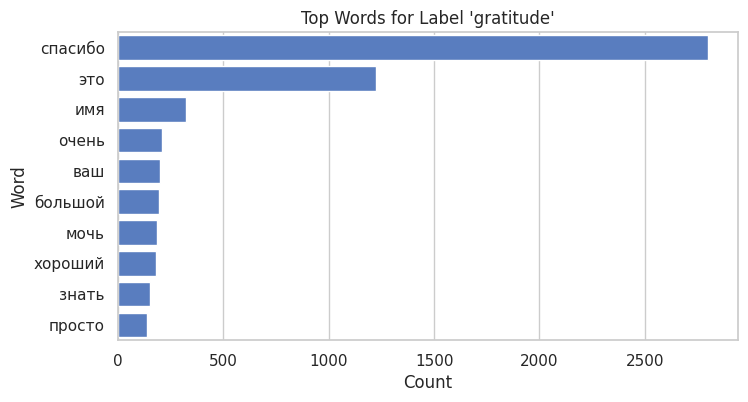

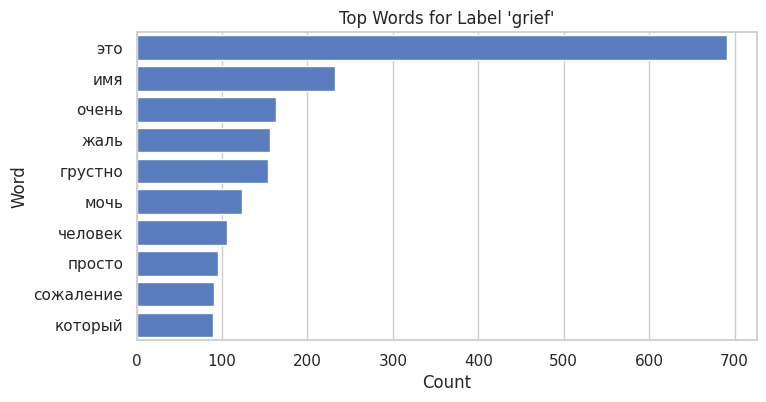

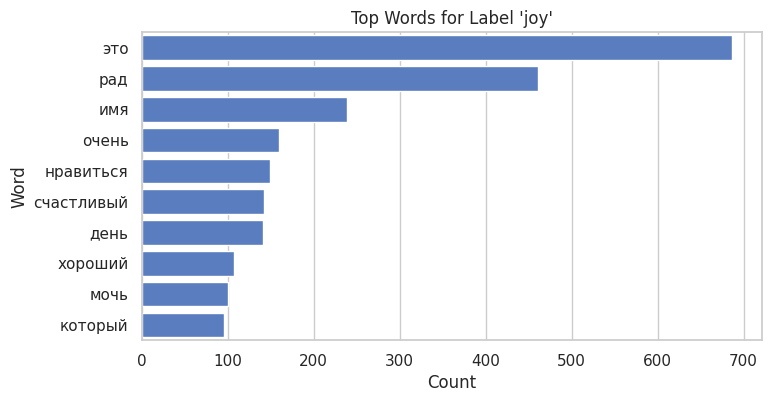

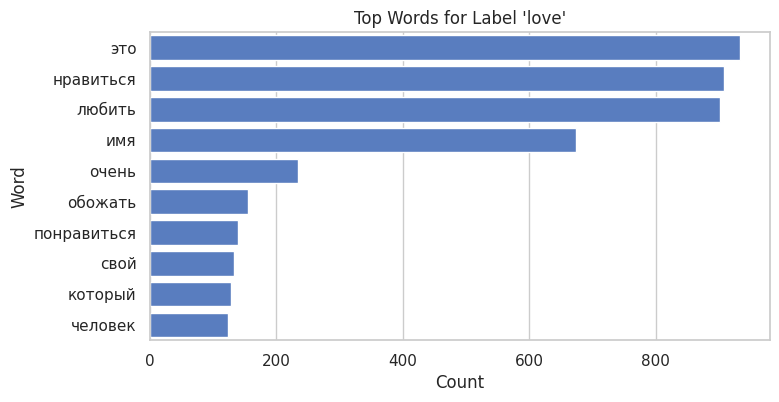

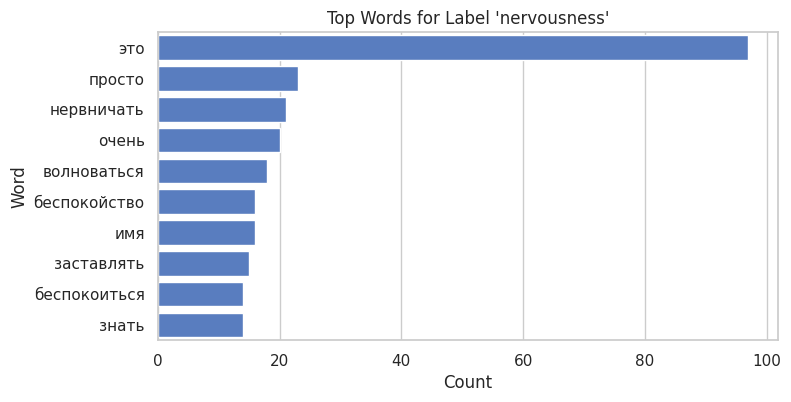

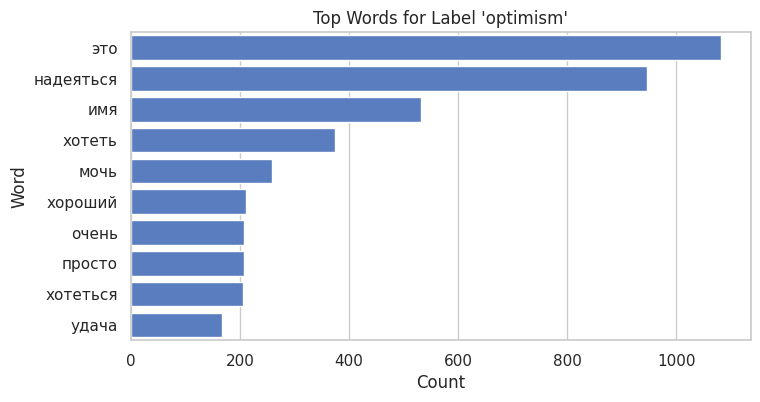

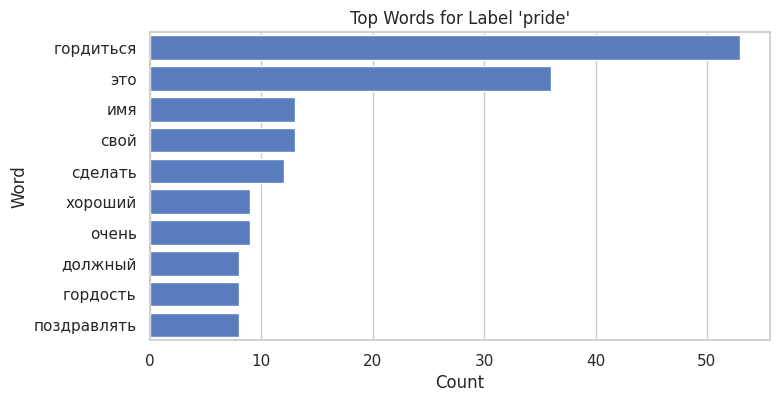

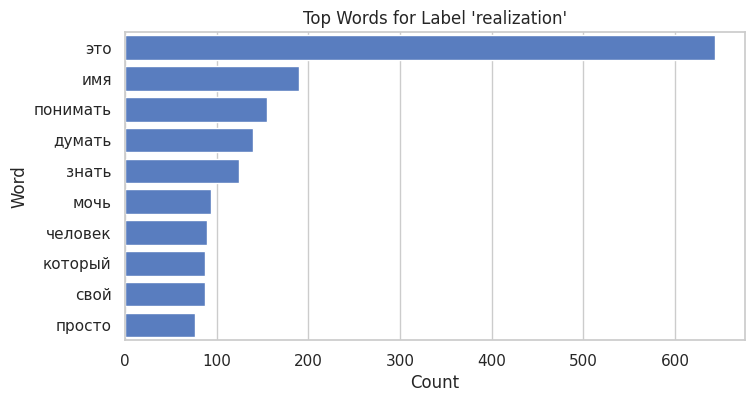

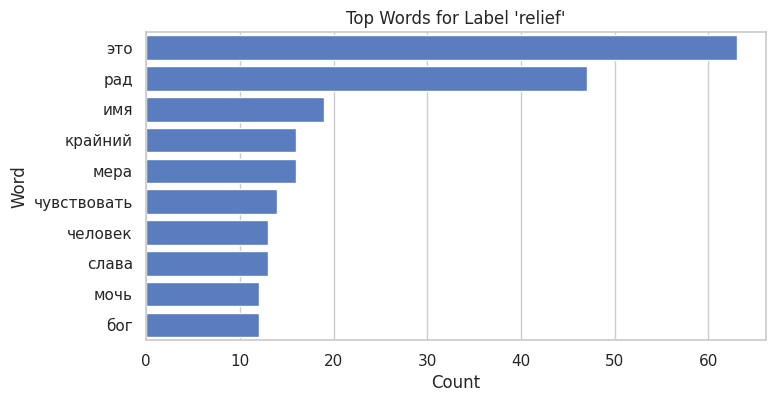

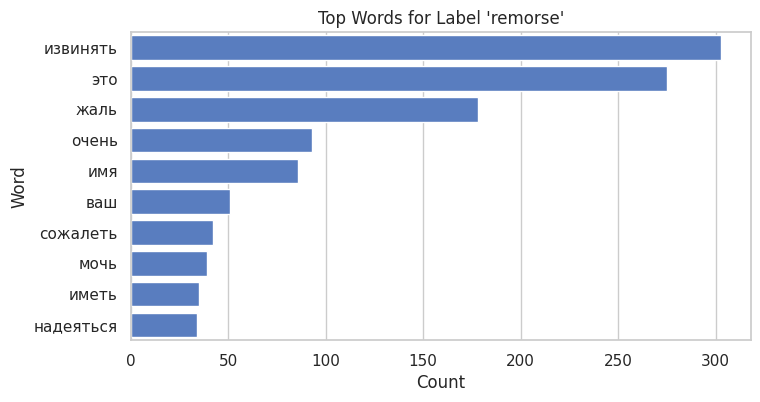

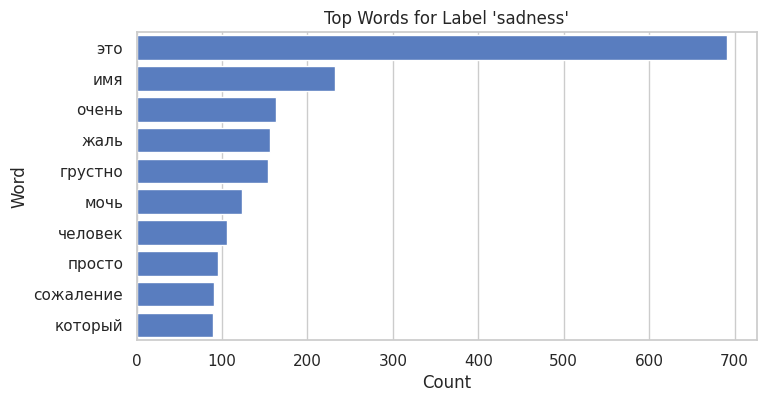

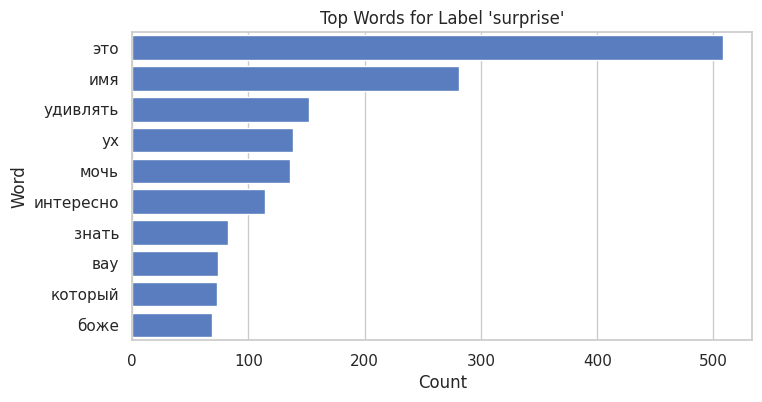

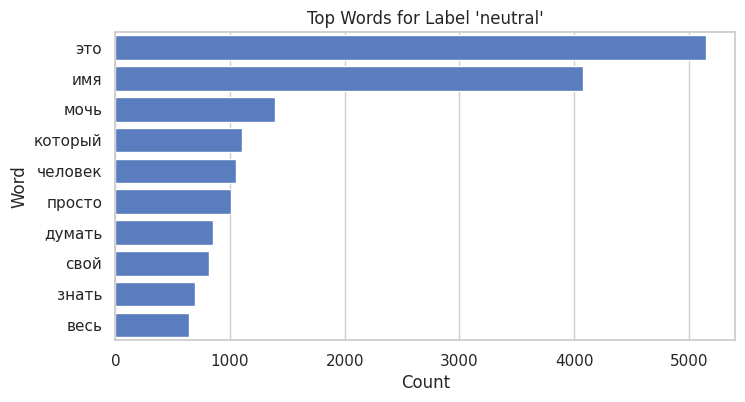

In [ ]:
for i in range(0, 28):
    label = i
    words = common_words[i]
    label_words_df = pd.DataFrame(words, columns=['word', 'count'])
    plt.figure(figsize=(8, 4))
    sns.barplot(x='count', y='word', data=label_words_df)
    plt.title(f"Top Words for Label '{emotion2id[label]}'")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()

Между классами очень много пересечений. Положительные эмоции часто пересекаются между собой, негативные - между собой. Нейтральные находят соответствия в лексике всех классов. Создать на основе этого rule-based подход будет сложно, так что мы обратимся к классическому ml и к моделям-трансформерам для решения задачи.

## 3. Препроцессинг

Для удобства создадим единый DataFrame только с колонками 'ru_text' и 'labels'

In [ ]:
df_preproc = df[['ru_text', 'labels']].dropna().reset_index(drop=True)

Разделим его на тренировочную/валидационную/тестовую части

In [ ]:
train_df, temporary_df = train_test_split(df_preproc, shuffle=True, test_size=0.3, random_state=42)
val_df, test_df  = train_test_split(temporary_df, test_size=0.5, random_state=42)

In [ ]:
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 37984, Val size: 8139, Test size: 8140


## 4. Baseline-решение

Опирались на [данный метод](https://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html) решения задачи multilabel classification

In [ ]:
# векторизуем данные с помощью Tfidf
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['ru_text'])
X_test = vectorizer.transform(test_df['ru_text'])

In [ ]:
# обрабатываем таргеты - из списка классов превращаем в вектор длиной 28, где каждая позиция - 1 или 0
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df['labels'].tolist())
y_test = mlb.transform(test_df['labels'].tolist())

Возьмем за основу логистическую регрессию и обернем её в OneVsRestClassifier, чтобы предсказывать для нашей задачи

In [ ]:
base_model = LogisticRegression(solver='liblinear', max_iter=1000)
ovr = OneVsRestClassifier(base_model)
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 solver='liblinear'))

Считать будем сходство Жаккарда (и по нему же будем оценивать и сравнивать модели). Сходство Жаккара измеряет пересечение между двумя последовательностями по сравнению с объединением двух последовательностей, что подходит нам для оценки пересечения двух последовательностей тэгов эмоций

Так же полученные предсказания сравним с оригинальным таргетом при помощи classification_report, чтобы посмотреть, насколько модель справляется с каждым классом по отдельности

In [ ]:
y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(y_test, y_pred_ovr, average='samples')

print("Baseline Model Performance:")
print(classification_report(y_test, y_pred_ovr, target_names=[emotion2id[x] for x in mlb.classes_]))
print(f"Jaccard Similarity Score: {ovr_jaccard_score:.4f}")

Baseline Model Performance:
                precision    recall  f1-score   support

    admiration       0.79      0.27      0.40       784
     amusement       0.79      0.47      0.59       409
         anger       0.64      0.06      0.10       288
     annoyance       0.56      0.01      0.02       441
      approval       0.62      0.04      0.08       567
        caring       0.44      0.02      0.04       216
     confusion       0.50      0.04      0.08       232
     curiosity       0.59      0.08      0.15       395
        desire       0.65      0.11      0.19       133
disappointment       1.00      0.00      0.01       239
   disapproval       0.41      0.04      0.07       389
       disgust       0.60      0.06      0.10       163
 embarrassment       0.00      0.00      0.00        52
    excitement       0.86      0.04      0.07       155
          fear       0.88      0.12      0.21       116
     gratitude       0.97      0.77      0.86       506
         grief     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Нам нужно смотреть на samples avg метрики. Судя по ним, модель справляется достаточно плохо: samples avg precision = 0.28, recall = 0.26, f1-score = 0.27.

Далее мы создадим 28 независимых экземпляров ClassifierChain с различными случайными порядками. Все цепочки основаны на base_model, которая передается в качестве базовой модели.


In [ ]:
chains = [ClassifierChain(base_model, order="random", random_state=i) for i in range(28)]
for chain in chains:
    chain.fit(X_train, y_train)

Для каждой цепочки делаются предсказания и вычисляется Jaccard индекс, который сравнивает истинные тестовые метки y_test с предсказанными метками (используя порог 0.5 для вероятностей).
Вероятности всех цепочек усредняются для создания ансамблевого прогноза. Затем вычисляется Jaccard индекс для этого ансамблевого прогноза.

In [ ]:
y_pred_chains = np.array([chain.predict_proba(X_test) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(y_test, y_pred_chain >= 0.5, average="samples")
    for y_pred_chain in y_pred_chains
]

y_pred_ensemble = y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    y_test, y_pred_ensemble >= 0.5, average="samples"
)

Тут мы посмотрим на то, какой подход оказался лучше

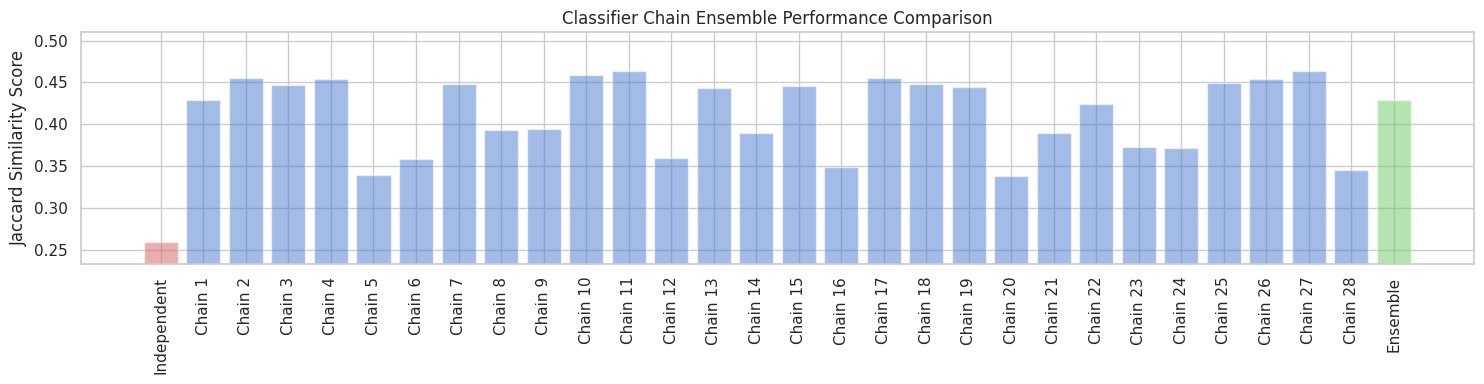

In [ ]:
model_scores = [ovr_jaccard_score] + chain_jaccard_scores + [ensemble_jaccard_score]

model_names = ("Independent", "Chain 1", "Chain 2", "Chain 3", "Chain 4", "Chain 5", "Chain 6", "Chain 7", "Chain 8",
               "Chain 9", "Chain 10", "Chain 11", "Chain 12", "Chain 13", "Chain 14", "Chain 15", "Chain 16", "Chain 17",
               "Chain 18", "Chain 19", "Chain 20", "Chain 21", "Chain 22", "Chain 23", "Chain 24", "Chain 25", "Chain 26",
               "Chain 27", "Chain 28", "Ensemble"
)

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(15, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Jaccard Similarity Score (Ensemble): {ensemble_jaccard_score:.4f}")
print(classification_report(y_test, y_pred_ensemble >= 0.5, target_names=[emotion2id[x] for x in mlb.classes_]))

Jaccard Similarity Score (Ensemble): 0.4295
                precision    recall  f1-score   support

    admiration       0.73      0.39      0.51       784
     amusement       0.80      0.57      0.67       409
         anger       0.65      0.10      0.17       288
     annoyance       0.38      0.02      0.03       441
      approval       0.61      0.08      0.15       567
        caring       0.48      0.06      0.10       216
     confusion       0.46      0.10      0.16       232
     curiosity       0.48      0.12      0.19       395
        desire       0.57      0.19      0.28       133
disappointment       1.00      0.01      0.02       239
   disapproval       0.38      0.05      0.09       389
       disgust       0.62      0.06      0.11       163
 embarrassment       0.00      0.00      0.00        52
    excitement       0.62      0.05      0.10       155
          fear       0.81      0.18      0.30       116
     gratitude       0.96      0.80      0.87       506
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ансмабль неплохо справился, но есть отдельные цепочки, которые превзошли его по качеству. Мы возьмем в качестве baseline модели нашу ансамблевую модель

## 5.1. Эксперимент 0*

Мы решили попробовать написать свою модель

In [ ]:
class CustomNN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(CustomNN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 256)
            self.dropout1 = nn.Dropout(0.3)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(256, 128)
            self.dropout2 = nn.Dropout(0.3)
            self.fc3 = nn.Linear(128, 64)
            self.fc4 = nn.Linear(64, output_dim)
            self.sigmoid = nn.Sigmoid()


        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout1(x)
            x = self.fc2(x)
            x = self.relu(x)
            x = self.dropout2(x)
            x = self.fc3(x)
            x = self.relu(x)
            x = self.fc4(x)
            x = self.sigmoid(x)
            return x

In [ ]:
# обрабатываем данные, как в 4.
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['ru_text']).toarray()
X_val = vectorizer.transform(val_df['ru_text']).toarray()
X_test = vectorizer.transform(test_df['ru_text']).toarray()

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df['labels'].tolist())
y_val = mlb.transform(val_df['labels'].tolist())
y_test = mlb.transform(test_df['labels'].tolist())

In [ ]:
total_samples = sum(class_sizes)
num_classes = len(class_sizes)

In [ ]:
model = CustomNN(input_dim=X_train.shape[1], output_dim=28)
weights = torch.tensor([1/10 for label in range(28)], dtype=torch.float32)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

В процессе обучения мы пробовали менять веса классов, lr, количество эпох и так далее, и ничего из этого не помогло для превышения качества baseline модели.

In [ ]:
for epoch in tqdm(range(50)):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    # считаем для разных порогов
    jaccard_05 = jaccard_score(y_val_tensor, val_outputs >= 0.5, average='samples')
    jaccard_03 = jaccard_score(y_val_tensor, val_outputs >= 0.3, average='samples')
    jaccard_01 = jaccard_score(y_val_tensor, val_outputs >= 0.1, average='samples')

    print(f"Epoch {epoch + 1}, Training Loss: {loss.item():.5f}, Validation Loss: {val_loss.item():.5f}, Jaccard Similarity (0.5): {jaccard_05:.5f}, Jaccard Similarity (0.3): {jaccard_03:.5f}, Jaccard Similarity (0.1): {jaccard_01:.5f}")


  2%|▏         | 1/50 [00:03<02:37,  3.21s/it]

Epoch 1, Training Loss: 3.90448, Validation Loss: 3.90458, Jaccard Similarity (0.5): 0.05910, Jaccard Similarity (0.3): 0.04211, Jaccard Similarity (0.1): 0.04211


  4%|▍         | 2/50 [00:06<02:36,  3.27s/it]

Epoch 2, Training Loss: 3.88693, Validation Loss: 3.86451, Jaccard Similarity (0.5): 0.08373, Jaccard Similarity (0.3): 0.04211, Jaccard Similarity (0.1): 0.04211


  6%|▌         | 3/50 [00:11<03:03,  3.90s/it]

Epoch 3, Training Loss: 3.84671, Validation Loss: 3.77769, Jaccard Similarity (0.5): 0.08948, Jaccard Similarity (0.3): 0.04415, Jaccard Similarity (0.1): 0.04211


  8%|▊         | 4/50 [00:14<02:47,  3.64s/it]

Epoch 4, Training Loss: 3.76066, Validation Loss: 3.67592, Jaccard Similarity (0.5): 0.08948, Jaccard Similarity (0.3): 0.07880, Jaccard Similarity (0.1): 0.04429


 10%|█         | 5/50 [00:17<02:35,  3.47s/it]

Epoch 5, Training Loss: 3.66179, Validation Loss: 3.63280, Jaccard Similarity (0.5): 0.08948, Jaccard Similarity (0.3): 0.08942, Jaccard Similarity (0.1): 0.07945


 12%|█▏        | 6/50 [00:21<02:32,  3.47s/it]

Epoch 6, Training Loss: 3.62081, Validation Loss: 3.62811, Jaccard Similarity (0.5): 0.08948, Jaccard Similarity (0.3): 0.08949, Jaccard Similarity (0.1): 0.08875


 14%|█▍        | 7/50 [00:25<02:41,  3.76s/it]

Epoch 7, Training Loss: 3.61667, Validation Loss: 3.62765, Jaccard Similarity (0.5): 0.08948, Jaccard Similarity (0.3): 0.08950, Jaccard Similarity (0.1): 0.08898


 16%|█▌        | 8/50 [00:28<02:30,  3.58s/it]

Epoch 8, Training Loss: 3.61627, Validation Loss: 3.62287, Jaccard Similarity (0.5): 0.08948, Jaccard Similarity (0.3): 0.08948, Jaccard Similarity (0.1): 0.08531


 18%|█▊        | 9/50 [00:31<02:22,  3.47s/it]

Epoch 9, Training Loss: 3.61131, Validation Loss: 3.62162, Jaccard Similarity (0.5): 0.09299, Jaccard Similarity (0.3): 0.08458, Jaccard Similarity (0.1): 0.08458


 20%|██        | 10/50 [00:35<02:24,  3.61s/it]

Epoch 10, Training Loss: 3.60996, Validation Loss: 3.61533, Jaccard Similarity (0.5): 0.10061, Jaccard Similarity (0.3): 0.09844, Jaccard Similarity (0.1): 0.08305


 22%|██▏       | 11/50 [00:39<02:23,  3.69s/it]

Epoch 11, Training Loss: 3.60271, Validation Loss: 3.62218, Jaccard Similarity (0.5): 0.08829, Jaccard Similarity (0.3): 0.08828, Jaccard Similarity (0.1): 0.08755


 24%|██▍       | 12/50 [00:42<02:13,  3.52s/it]

Epoch 12, Training Loss: 3.61337, Validation Loss: 3.61704, Jaccard Similarity (0.5): 0.09436, Jaccard Similarity (0.3): 0.08948, Jaccard Similarity (0.1): 0.08807


 26%|██▌       | 13/50 [00:45<02:06,  3.43s/it]

Epoch 13, Training Loss: 3.60757, Validation Loss: 3.61568, Jaccard Similarity (0.5): 0.10119, Jaccard Similarity (0.3): 0.09444, Jaccard Similarity (0.1): 0.09442


 28%|██▊       | 14/50 [00:50<02:12,  3.67s/it]

Epoch 14, Training Loss: 3.60546, Validation Loss: 3.61795, Jaccard Similarity (0.5): 0.10880, Jaccard Similarity (0.3): 0.10079, Jaccard Similarity (0.1): 0.09455


 30%|███       | 15/50 [00:53<02:04,  3.55s/it]

Epoch 15, Training Loss: 3.60661, Validation Loss: 3.61858, Jaccard Similarity (0.5): 0.11084, Jaccard Similarity (0.3): 0.10047, Jaccard Similarity (0.1): 0.09904


 32%|███▏      | 16/50 [00:56<01:57,  3.44s/it]

Epoch 16, Training Loss: 3.60634, Validation Loss: 3.61665, Jaccard Similarity (0.5): 0.10051, Jaccard Similarity (0.3): 0.10021, Jaccard Similarity (0.1): 0.09434


 34%|███▍      | 17/50 [00:59<01:51,  3.39s/it]

Epoch 17, Training Loss: 3.60436, Validation Loss: 3.61836, Jaccard Similarity (0.5): 0.10835, Jaccard Similarity (0.3): 0.10037, Jaccard Similarity (0.1): 0.09389


 36%|███▌      | 18/50 [01:04<02:00,  3.76s/it]

Epoch 18, Training Loss: 3.60444, Validation Loss: 3.61475, Jaccard Similarity (0.5): 0.10323, Jaccard Similarity (0.3): 0.09430, Jaccard Similarity (0.1): 0.09315


 38%|███▊      | 19/50 [01:07<01:52,  3.63s/it]

Epoch 19, Training Loss: 3.60038, Validation Loss: 3.61434, Jaccard Similarity (0.5): 0.09426, Jaccard Similarity (0.3): 0.09386, Jaccard Similarity (0.1): 0.08965


 40%|████      | 20/50 [01:11<01:46,  3.54s/it]

Epoch 20, Training Loss: 3.60038, Validation Loss: 3.60699, Jaccard Similarity (0.5): 0.09722, Jaccard Similarity (0.3): 0.09109, Jaccard Similarity (0.1): 0.08966


 42%|████▏     | 21/50 [01:14<01:43,  3.57s/it]

Epoch 21, Training Loss: 3.59365, Validation Loss: 3.60442, Jaccard Similarity (0.5): 0.10444, Jaccard Similarity (0.3): 0.09862, Jaccard Similarity (0.1): 0.08966


 44%|████▍     | 22/50 [01:19<01:46,  3.79s/it]

Epoch 22, Training Loss: 3.59141, Validation Loss: 3.60302, Jaccard Similarity (0.5): 0.09600, Jaccard Similarity (0.3): 0.08973, Jaccard Similarity (0.1): 0.08969


 46%|████▌     | 23/50 [01:22<01:39,  3.67s/it]

Epoch 23, Training Loss: 3.58984, Validation Loss: 3.60178, Jaccard Similarity (0.5): 0.09734, Jaccard Similarity (0.3): 0.09658, Jaccard Similarity (0.1): 0.09219


 48%|████▊     | 24/50 [01:25<01:32,  3.57s/it]

Epoch 24, Training Loss: 3.58488, Validation Loss: 3.59980, Jaccard Similarity (0.5): 0.10326, Jaccard Similarity (0.3): 0.10084, Jaccard Similarity (0.1): 0.08938


 50%|█████     | 25/50 [01:31<01:44,  4.18s/it]

Epoch 25, Training Loss: 3.58130, Validation Loss: 3.59711, Jaccard Similarity (0.5): 0.09163, Jaccard Similarity (0.3): 0.08911, Jaccard Similarity (0.1): 0.08585


 52%|█████▏    | 26/50 [01:34<01:34,  3.92s/it]

Epoch 26, Training Loss: 3.57583, Validation Loss: 3.58595, Jaccard Similarity (0.5): 0.10500, Jaccard Similarity (0.3): 0.10274, Jaccard Similarity (0.1): 0.09729


 54%|█████▍    | 27/50 [01:38<01:25,  3.73s/it]

Epoch 27, Training Loss: 3.56382, Validation Loss: 3.58537, Jaccard Similarity (0.5): 0.12299, Jaccard Similarity (0.3): 0.11851, Jaccard Similarity (0.1): 0.10554


 56%|█████▌    | 28/50 [01:41<01:19,  3.60s/it]

Epoch 28, Training Loss: 3.56248, Validation Loss: 3.58236, Jaccard Similarity (0.5): 0.12730, Jaccard Similarity (0.3): 0.12119, Jaccard Similarity (0.1): 0.11164


 58%|█████▊    | 29/50 [01:45<01:21,  3.89s/it]

Epoch 29, Training Loss: 3.55517, Validation Loss: 3.58015, Jaccard Similarity (0.5): 0.13497, Jaccard Similarity (0.3): 0.12111, Jaccard Similarity (0.1): 0.10751


 60%|██████    | 30/50 [01:49<01:13,  3.69s/it]

Epoch 30, Training Loss: 3.55074, Validation Loss: 3.57646, Jaccard Similarity (0.5): 0.11281, Jaccard Similarity (0.3): 0.10995, Jaccard Similarity (0.1): 0.10615


 62%|██████▏   | 31/50 [01:52<01:07,  3.54s/it]

Epoch 31, Training Loss: 3.54708, Validation Loss: 3.57609, Jaccard Similarity (0.5): 0.11386, Jaccard Similarity (0.3): 0.11155, Jaccard Similarity (0.1): 0.10827


 64%|██████▍   | 32/50 [01:56<01:05,  3.64s/it]

Epoch 32, Training Loss: 3.54490, Validation Loss: 3.57033, Jaccard Similarity (0.5): 0.11770, Jaccard Similarity (0.3): 0.11411, Jaccard Similarity (0.1): 0.10964


 66%|██████▌   | 33/50 [02:00<01:03,  3.76s/it]

Epoch 33, Training Loss: 3.53655, Validation Loss: 3.56300, Jaccard Similarity (0.5): 0.12894, Jaccard Similarity (0.3): 0.12113, Jaccard Similarity (0.1): 0.11274


 68%|██████▊   | 34/50 [02:03<00:57,  3.60s/it]

Epoch 34, Training Loss: 3.52609, Validation Loss: 3.55798, Jaccard Similarity (0.5): 0.12925, Jaccard Similarity (0.3): 0.12248, Jaccard Similarity (0.1): 0.11167


 70%|███████   | 35/50 [02:06<00:52,  3.48s/it]

Epoch 35, Training Loss: 3.51942, Validation Loss: 3.55508, Jaccard Similarity (0.5): 0.12166, Jaccard Similarity (0.3): 0.11629, Jaccard Similarity (0.1): 0.10906


 72%|███████▏  | 36/50 [02:10<00:51,  3.69s/it]

Epoch 36, Training Loss: 3.51564, Validation Loss: 3.55086, Jaccard Similarity (0.5): 0.12183, Jaccard Similarity (0.3): 0.11667, Jaccard Similarity (0.1): 0.11081


 74%|███████▍  | 37/50 [02:14<00:47,  3.67s/it]

Epoch 37, Training Loss: 3.50700, Validation Loss: 3.54727, Jaccard Similarity (0.5): 0.12632, Jaccard Similarity (0.3): 0.12071, Jaccard Similarity (0.1): 0.11319


 76%|███████▌  | 38/50 [02:17<00:42,  3.52s/it]

Epoch 38, Training Loss: 3.49862, Validation Loss: 3.54567, Jaccard Similarity (0.5): 0.12749, Jaccard Similarity (0.3): 0.12234, Jaccard Similarity (0.1): 0.11365


 78%|███████▊  | 39/50 [02:20<00:37,  3.41s/it]

Epoch 39, Training Loss: 3.49445, Validation Loss: 3.54215, Jaccard Similarity (0.5): 0.12555, Jaccard Similarity (0.3): 0.12028, Jaccard Similarity (0.1): 0.11201


 80%|████████  | 40/50 [02:25<00:37,  3.73s/it]

Epoch 40, Training Loss: 3.48723, Validation Loss: 3.53784, Jaccard Similarity (0.5): 0.12467, Jaccard Similarity (0.3): 0.11912, Jaccard Similarity (0.1): 0.11170


 82%|████████▏ | 41/50 [02:28<00:32,  3.57s/it]

Epoch 41, Training Loss: 3.48268, Validation Loss: 3.53549, Jaccard Similarity (0.5): 0.12520, Jaccard Similarity (0.3): 0.12044, Jaccard Similarity (0.1): 0.11288


 84%|████████▍ | 42/50 [02:31<00:27,  3.45s/it]

Epoch 42, Training Loss: 3.47982, Validation Loss: 3.53433, Jaccard Similarity (0.5): 0.12777, Jaccard Similarity (0.3): 0.12337, Jaccard Similarity (0.1): 0.11555


 86%|████████▌ | 43/50 [02:34<00:23,  3.37s/it]

Epoch 43, Training Loss: 3.47360, Validation Loss: 3.53592, Jaccard Similarity (0.5): 0.12976, Jaccard Similarity (0.3): 0.12583, Jaccard Similarity (0.1): 0.11900


 88%|████████▊ | 44/50 [02:39<00:22,  3.74s/it]

Epoch 44, Training Loss: 3.47041, Validation Loss: 3.53529, Jaccard Similarity (0.5): 0.13169, Jaccard Similarity (0.3): 0.12824, Jaccard Similarity (0.1): 0.12171


 90%|█████████ | 45/50 [02:42<00:17,  3.60s/it]

Epoch 45, Training Loss: 3.46655, Validation Loss: 3.53187, Jaccard Similarity (0.5): 0.13263, Jaccard Similarity (0.3): 0.12973, Jaccard Similarity (0.1): 0.12406


 92%|█████████▏| 46/50 [02:45<00:13,  3.50s/it]

Epoch 46, Training Loss: 3.46016, Validation Loss: 3.52935, Jaccard Similarity (0.5): 0.13341, Jaccard Similarity (0.3): 0.13074, Jaccard Similarity (0.1): 0.12451


 94%|█████████▍| 47/50 [02:49<00:10,  3.43s/it]

Epoch 47, Training Loss: 3.45598, Validation Loss: 3.52835, Jaccard Similarity (0.5): 0.13409, Jaccard Similarity (0.3): 0.13139, Jaccard Similarity (0.1): 0.12559


 96%|█████████▌| 48/50 [02:53<00:07,  3.70s/it]

Epoch 48, Training Loss: 3.45241, Validation Loss: 3.52930, Jaccard Similarity (0.5): 0.13475, Jaccard Similarity (0.3): 0.13214, Jaccard Similarity (0.1): 0.12644


 98%|█████████▊| 49/50 [02:56<00:03,  3.54s/it]

Epoch 49, Training Loss: 3.44864, Validation Loss: 3.52766, Jaccard Similarity (0.5): 0.13579, Jaccard Similarity (0.3): 0.13304, Jaccard Similarity (0.1): 0.12703


100%|██████████| 50/50 [02:59<00:00,  3.60s/it]

Epoch 50, Training Loss: 3.44456, Validation Loss: 3.52414, Jaccard Similarity (0.5): 0.13665, Jaccard Similarity (0.3): 0.13401, Jaccard Similarity (0.1): 0.12766


In [ ]:
with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs, y_test_tensor)

print(f"Jaccard similarity on test dataset: {jaccard_score(y_test_tensor, outputs >= 0.5, average='samples'):.5f}")
print(classification_report(y_test_tensor, outputs >= 0.5, target_names=[emotion2id[x] for x in mlb.classes_]))

Jaccard similarity on test dataset: 0.13567
                precision    recall  f1-score   support

    admiration       0.10      1.00      0.18       784
     amusement       0.25      0.68      0.37       409
         anger       0.00      0.00      0.00       288
     annoyance       0.07      0.60      0.13       441
      approval       0.07      0.85      0.13       567
        caring       0.00      0.00      0.00       216
     confusion       0.00      0.00      0.00       232
     curiosity       0.08      0.58      0.13       395
        desire       0.00      0.00      0.00       133
disappointment       0.00      0.00      0.00       239
   disapproval       0.08      0.61      0.15       389
       disgust       0.00      0.00      0.00       163
 embarrassment       0.00      0.00      0.00        52
    excitement       0.00      0.00      0.00       155
          fear       0.00      0.00      0.00       116
     gratitude       0.06      0.88      0.12       506
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


После этого эксперимента мы пришли к выводу, что созданная нами модель слишком проста для того, чтобы уловить закономерности в датасете. Кроме того, дисбаланс классов сильно влияет на качество

## 5.2. Эксперимент 1

В этом эксперименте мы решили попробовать предсказывать лейблы с помощью деревьев, обернутых в MultiOutputClassifier

In [ ]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
base_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model = MultiOutputClassifier(base_model)

In [ ]:
model.fit(X_train_scaled, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

In [ ]:
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

In [ ]:
jaccard_05_val = jaccard_score(y_val, y_val_pred, average='samples')
print(f"Jaccard Similarity (Validation): {jaccard_05_val:.5f}")

Jaccard Similarity (Validation): 0.28093


In [ ]:
jaccard_05_test = jaccard_score(y_test, y_test_pred, average='samples')
print(f"Jaccard Similarity (Test): {jaccard_05_test:.5f}")

Jaccard Similarity (Test): 0.28120


In [ ]:
print("\nClassification Report on Test Dataset:")
print(classification_report(y_test, y_test_pred, target_names=[emotion2id[x] for x in mlb.classes_]))


Classification Report on Test Dataset:
                precision    recall  f1-score   support

    admiration       0.71      0.34      0.46       784
     amusement       0.74      0.56      0.64       409
         anger       0.39      0.12      0.19       288
     annoyance       0.12      0.02      0.03       441
      approval       0.40      0.06      0.10       567
        caring       0.47      0.07      0.12       216
     confusion       0.59      0.04      0.08       232
     curiosity       0.38      0.08      0.13       395
        desire       0.68      0.11      0.19       133
disappointment       0.15      0.01      0.02       239
   disapproval       0.29      0.03      0.05       389
       disgust       0.41      0.09      0.14       163
 embarrassment       0.01      0.02      0.01        52
    excitement       0.09      0.10      0.09       155
          fear       0.80      0.21      0.33       116
     gratitude       0.95      0.76      0.85       506
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Результаты получились лучше, чем в эксперименте 0, но всё ещё хуже, чем в baseline модели

##  6.1. Эксперимент 2

Мы решили взять предобученную модель и сделать fine-tuning на наших данных

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=28,
    problem_type="multi_label_classification",
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# пишем датасет самостоятельно
class EmotionDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_len=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_len = max_len

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            labels = self.labels[idx]

            encoding = self.tokenizer(
                text,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'labels': torch.tensor(labels, dtype=torch.float)
            }

In [ ]:
# таргеты обрабатываем так же, как в пред. пунктах
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df['labels'].tolist())
y_val = mlb.transform(val_df['labels'].tolist())
y_test = mlb.transform(test_df['labels'].tolist())

# текста обраюатываем с помощью созданного нами датасета
train_dataset = EmotionDataset(
    train_df['ru_text'].tolist(),
    y_train,
    tokenizer
)

val_dataset = EmotionDataset(
    val_df['ru_text'].tolist(),
    y_val,
    tokenizer
)

test_dataset = EmotionDataset(
    test_df['ru_text'].tolist(),
    y_test,
    tokenizer
)

In [ ]:
# и преобразуем их в dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# добавляем штуки для оптимизации процесса дообучения
from transformers import get_scheduler
optimizer = AdamW(model.parameters(), lr=0.005)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
# обучение
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # рассчитываем предсказания
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # считаем ошибку
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # делаем шаг
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")

    # валидация
    model.eval()
    all_preds = []
    all_labels = []
    total_val_loss = 0
    with torch.no_grad():
      # аналогично с train_loader, только не учимся на этих данных
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            total_val_loss += loss.item()

            preds = torch.sigmoid(logits).cpu().numpy() > 0.3

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    try:
      jaccard = jaccard_score(all_labels, all_preds, average='samples')
      print(f"Validation Loss: {avg_val_loss}, Jaccard Score: {jaccard:.4f}")
    finally:
      print(f"Validation Loss: {avg_val_loss}")

100%|██████████| 1187/1187 [12:38<00:00,  1.56it/s]


Epoch 1, Training Loss: 0.1703


100%|██████████| 255/255 [00:52<00:00,  4.82it/s]


Validation Loss: 0.16661585797281825, Jaccard Score: 0.0000
Validation Loss: 0.16661585797281825


100%|██████████| 1187/1187 [12:39<00:00,  1.56it/s]


Epoch 2, Training Loss: 0.1608


100%|██████████| 255/255 [00:52<00:00,  4.83it/s]


Validation Loss: 0.15485003120174595, Jaccard Score: 0.0000
Validation Loss: 0.15485003120174595


100%|██████████| 1187/1187 [12:38<00:00,  1.56it/s]


Epoch 3, Training Loss: 0.1539


100%|██████████| 255/255 [00:52<00:00,  4.86it/s]

Validation Loss: 0.14961036592721938, Jaccard Score: 0.3067
Validation Loss: 0.14961036592721938


In [ ]:
# оцениваем модель на тестовом датасете
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
      for batch in tqdm(test_loader):
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          logits = outputs.logits
          preds = torch.sigmoid(logits).cpu().numpy() > 0.3

          all_preds.extend(preds)
          all_labels.extend(labels.cpu().numpy())

100%|██████████| 255/255 [00:52<00:00,  4.84it/s]


In [ ]:
jaccard = jaccard_score(all_labels, all_preds, average='samples')
print(f"Jaccard Score: {jaccard:.4f}")
print(classification_report(all_labels, all_preds))

Jaccard Score: 0.3161
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       784
           1       0.00      0.00      0.00       409
           2       0.00      0.00      0.00       288
           3       0.00      0.00      0.00       441
           4       0.00      0.00      0.00       567
           5       0.00      0.00      0.00       216
           6       0.00      0.00      0.00       232
           7       0.00      0.00      0.00       395
           8       0.00      0.00      0.00       133
           9       0.00      0.00      0.00       239
          10       0.00      0.00      0.00       389
          11       0.00      0.00      0.00       163
          12       0.00      0.00      0.00        52
          13       0.00      0.00      0.00       155
          14       0.00      0.00      0.00       116
          15       0.00      0.00      0.00       506
          16       0.00      0.00      0.00        21
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Как можно видеть по показателям, модель справляется плохо, так как умеет работать только с одним классом - самым многочисленным - neutral. по recall видно, что модель просто все объекты заносит в neutral, и только этим достигает хоть какого-то качества

## 6.2. Эксперимент 2 (другой вариант)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

Мы обнаружили, что модель seara/rubert-base-cased-russian-emotion-detection-ru-go-emotions обучалась на датасете, с которым мы работаем, и подумали, что она могла бы быть полезна для нас этим

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-base-cased-russian-emotion-detection-ru-go-emotions")
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-base-cased-russian-emotion-detection-ru-go-emotions", num_labels=28)

In [ ]:
# создаем датасет сами
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

In [ ]:
mlb = MultiLabelBinarizer()
# преобразуем метки для train, val и test
y_train = mlb.fit_transform(df_train['labels'])
y_val = mlb.transform(df_val['labels'])
y_test = mlb.transform(df_test['labels'])

In [ ]:
# преобразуем данные для дальнейшей работы с моделью
train_dataset = EmotionDataset(
    texts=df_train['text'].tolist(),
    labels=y_train,
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = EmotionDataset(
    texts=df_val['text'].tolist(),
    labels=y_val,
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = EmotionDataset(
    texts=df_test['text'].tolist(),
    labels=y_test,
    tokenizer=tokenizer,
    max_len=128
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# опять штуки для оптимизации процесса обучени
from transformers import get_scheduler
optimizer = AdamW(model.parameters(), lr=0.005)
num_training_steps = len(train_loader) * 5  # 5 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
# функция для обучения
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    return total_loss / len(loader)

In [ ]:
# функция для оценивания модели
def eval_model(model, loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits).cpu().numpy() > 0.3).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), np.vstack(all_preds), np.vstack(all_labels)

In [ ]:
n_epochs = 5

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch + 1}/{n_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_preds, val_labels = eval_model(model, val_loader, criterion, device)

    jaccard = jaccard_score(val_labels, val_preds, average='samples')
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Jaccard Score: {jaccard:.4f}")


Epoch 1/5


Validation: 100%|██████████| 170/170 [00:32<00:00,  5.23it/s]


Training Loss: 0.1718, Validation Loss: 0.1651, Jaccard Score: 0.0000

Epoch 2/5


Validation: 100%|██████████| 170/170 [00:32<00:00,  5.22it/s]


Training Loss: 0.1665, Validation Loss: 0.1610, Jaccard Score: 0.3092

Epoch 3/5


Validation: 100%|██████████| 170/170 [00:32<00:00,  5.23it/s]


Training Loss: 0.1626, Validation Loss: 0.1594, Jaccard Score: 0.3092

Epoch 4/5


Validation: 100%|██████████| 170/170 [00:32<00:00,  5.23it/s]


Training Loss: 0.1575, Validation Loss: 0.1542, Jaccard Score: 0.0000

Epoch 5/5


Validation: 100%|██████████| 170/170 [00:32<00:00,  5.21it/s]

Training Loss: 0.1525, Validation Loss: 0.1495, Jaccard Score: 0.3092


In [ ]:
# предсказываем для теста
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = (torch.sigmoid(logits).cpu().numpy() > 0.3).astype(int)

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

Testing: 100%|██████████| 170/170 [00:32<00:00,  5.23it/s]


И оцениваем полученные тестовые предсказания

In [ ]:
jaccard = jaccard_score(all_labels, all_preds, average='samples')
print(f"Jaccard Score: {jaccard:.4f}")
print(classification_report(all_labels, all_preds))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Jaccard Score: 0.3123
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       504
           1       0.00      0.00      0.00       264
           2       0.00      0.00      0.00       198
           3       0.00      0.00      0.00       320
           4       0.00      0.00      0.00       351
           5       0.00      0.00      0.00       135
           6       0.00      0.00      0.00       153
           7       0.00      0.00      0.00       284
           8       0.00      0.00      0.00        83
           9       0.00      0.00      0.00       151
          10       0.00      0.00      0.00       267
          11       0.00      0.00      0.00       123
          12       0.00      0.00      0.00        37
          13       0.00      0.00      0.00       103
          14       0.00      0.00      0.00        78
          15       0.00      0.00      0.00       352
          16       0.00      0.00      0.00         6
     

Возникает такая же проблема, как и в предыдущем пункте с моделью Bert. (определять веса классов пробовали - не сработало).

## Оценка результатов

В заключение можно попробовать проанализировать, почему ни один из подходов не сумел побить baseline решения и как это можно было бы исправить, будь у нас чуть больше времени:

- дисбаланс классов и их относительно большое количество (28). можно было бы обрезать данные из больших классов (neutral и др.), но это может привести к тому, что модель вообще никакие закономерности в классах не вычисляет. можно было бы добавить в маленькие классы синтетических данных
-  слишком сложные закономерности для одной модели, даже очень большой: можно было бы, например, обучить 28 нейросетей, каждая по принципу one VS rest, и финальные предсказания делать аггрегацией предсказаний каждой из них. но тогда всё равно столкнемся с проблемой - one будет сильно меньше по объему данных, чем rest